# Imports and method


In [9]:
from carbontracker import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics
import os
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
#import Models as M
!pip3 install patchify
import patchify as Pf
from PIL import Image
from sklearn.metrics import precision_recall_curve
from datetime import datetime
from torchvision import models
import os
!pip install carbontracker

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [10]:
os.chdir(os.getcwd())

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        self.ax.legend
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def set_xlabel(self, label, labelpad=None):
        self.ax.set_xlabel(label, labelpad=labelpad)


In [17]:
# Open the log file for reading
def process_log_files(log_files):
    time_values = []
    energy_values = []
    co2eq_values = []
    for log_file_path in log_files:
        # Open the log file for reading
        with open(log_file_path, 'r') as file:
            read_values = False
            for line in file:
                if 'Actual consumption' in line:
                    read_values = True
                elif read_values and line.strip() != '':
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        label = parts[0].strip()
                        value = parts[1].strip()
                        if label == 'Time:':
                            hours, minutes, seconds = value.split(':')
                            total_min = int(int(hours) * 3600 + int(minutes) * 60 + int(seconds))/60
                            time_values.append(total_min)
                        elif label == 'Energy:':
                            energy = float(value.rstrip(' kWh'))
                            energy_values.append(energy)
                        elif label == 'CO2eq:':
                            co2eq = float(value.rstrip(' g'))
                            co2eq_values.append(co2eq)
                elif 'CarbonTracker: Finished monitoring.' in line:
                    break
    return time_values, energy_values, co2eq_values

In [30]:
def plot_radar(labels, acc_values_1, time_values, energy_values, co2eq_values, somelabel = 'pølse'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'$|\theta|(M)$   ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0.6, 0.8), (0, 0.5), (20,45), (100, 130)])
    for i in range(len(time_values)):
        data = (acc_values_1[i], energy_values[i], co2eq_values[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Distribution Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

In [31]:
os.chdir(os.getcwd())
path = 'Data/Synthetic_Alzheimer_MRI/CarbonLogs/'
end = '.log'

In [32]:
from functools import reduce
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

# ConvNet DM

Time values: [102.81666666666666, 103.95, 123.1]
Energy values: [0.284152, 0.285919, 0.308364]
CO2eq values: [24.315317, 30.797603, 39.059439]


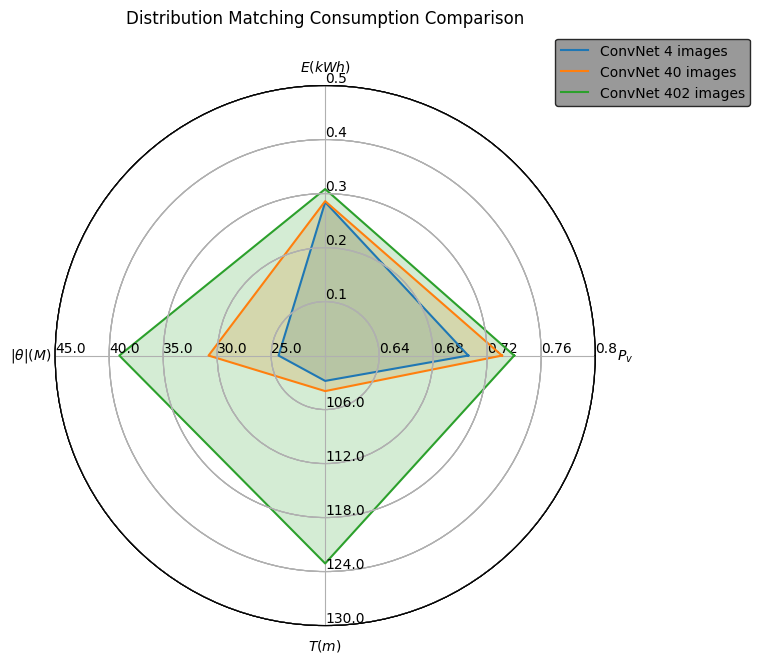

In [33]:
log_files_DM = [f'{path}CARBON_T_DM_LR1_k20000_4ConvNet2_14556_2023-05-19T005308Z_carbontracker_output{end}'
                  ,f'{path}CARBON_T_DM_LR1_k20000_40ConvNet2_18504_2023-05-18T225134Z_carbontracker_output{end}'
                  ,f'{path}CARBON_T_DM_LR1_k20000_402ConvNet2_10000_2023-05-18T204032Z_carbontracker_output{end}'
                  ] 

time_values1, energy_values1, co2eq_values1 = process_log_files(log_files_DM)

acc_values_1= [0.706, 0.731, 0.74]

# Print the extracted values
print("Time values:", time_values1)
print("Energy values:", energy_values1)
print("CO2eq values:", co2eq_values1)

labels = ['ConvNet 4 images', 'ConvNet 40 images', 'ConvNet 402 images']
plot_radar(labels, acc_values_1, time_values1, energy_values1, co2eq_values1) #somelabel = something